# Capstone Project Week 1 Assignment

# Tornados and Trailer Parks

It is a well-known fact that when a tornado touches down the first thing it does is ask for 
directions to the nearest trailer park.  This is an unfortunate thing for people who live in trailer 
parks (as I did when I was a kid).  

There is a dataset out there that contains statistical information on every tornado in the US from 
1950 to 2015.  So it occurred to me that this data might be useful in determining the best place to 
build a trailer park in the US.

Now I have come to understand from reputable sources that tornados are spawned as a result of pre-
existing conditions.  They don't actually get to choose where they are going to touchdown.  So they
can't in a targeted way just drop in on a specific trailer park.

Therefore, there must exist some optimal location to build a trailer park which is removed from the
areas where tornados frequently spawn.

Our goal in this effort is to find that sweet spot if.  This information should prove invaluable not 
only to developers who are looking to build new trailer parks, but to trailer owners who are looking 
for a place to park them.

# Import our tornados .csv file into a pandas dataset

In [1]:
import pandas as pd

df = pd.read_csv (r'Tornadoes_SPC_1950to2015.csv')

df.head()

,om,yr,mo,dy,date,time,tz,st,stf,stn,...,fat,loss,closs,slat,slon,elat,elon,len,wid,fc
0,1,1950,1,3,1/3/1950,11:00:00,3,MO,29,1,...,0,6.0,0.0,38.77,-90.22,38.83,-90.03,9.5,150,0
1,2,1950,1,3,1/3/1950,11:55:00,3,IL,17,2,...,0,5.0,0.0,39.10,-89.30,39.12,-89.23,3.6,130,0
2,3,1950,1,3,1/3/1950,16:00:00,3,OH,39,1,...,0,4.0,0.0,40.88,-84.58,0.00,0.00,0.1,10,0
3,4,1950,1,13,1/13/1950,5:25:00,3,AR,5,1,...,1,3.0,0.0,34.40,-94.37,0.00,0.00,0.6,17,0
4,5,1950,1,25,1/25/1950,19:30:00,3,MO,29,2,...,0,5.0,0.0,37.60,-90.68,37.63,-90.65,2.3,300,0


So the fields in this dataset are as follows:
om = tornado number within a given year
yr = year
mo = month
dy = day
date = date in MM/DD/YYYY format
time = time of tornado 'birth'
tz = time zone
st = State
stf = a numeric code for the state (we'll drop this column as we don't need it)
stn = the number of this tornado in it's home state in a given year
mag = magnitude of tornado on the EF scale (F0 - F5)
inj = number of injuries
fat = number of fatalities
loss = property loss where 1 <= $50, 2 <= $500, 3 <= $5,000, 4 <= $50,000, 5 <= $500,000 and so on.
closs = crop loss
slat = starting latitude
slon = starting longitude
elat = ending latitude
elon = ending longitude (not to be confused with Elon Musk)
len = length in miles
wid = width in yards
fc = a composite code that contains info on multiple states affected.  Earlier entries lack this so we will drop it.

# Drop the columns we don't need

In [2]:
df = df.drop(["stf", "fc"], axis=1)

df.head()

,om,yr,mo,dy,date,time,tz,st,stn,mag,inj,fat,loss,closs,slat,slon,elat,elon,len,wid
0,1,1950,1,3,1/3/1950,11:00:00,3,MO,1,3,3,0,6.0,0.0,38.77,-90.22,38.83,-90.03,9.5,150
1,2,1950,1,3,1/3/1950,11:55:00,3,IL,2,3,3,0,5.0,0.0,39.10,-89.30,39.12,-89.23,3.6,130
2,3,1950,1,3,1/3/1950,16:00:00,3,OH,1,1,1,0,4.0,0.0,40.88,-84.58,0.00,0.00,0.1,10
3,4,1950,1,13,1/13/1950,5:25:00,3,AR,1,3,1,1,3.0,0.0,34.40,-94.37,0.00,0.00,0.6,17
4,5,1950,1,25,1/25/1950,19:30:00,3,MO,2,2,5,0,5.0,0.0,37.60,-90.68,37.63,-90.65,2.3,300


# How many tornados in our dataframe?

In [3]:
df.shape

(60114, 20)

Hmmm...  Sixty thousand tornados.  If we are going to plot these on a map it's going to be pretty 
cluttered.  In fact we won't be able to see much else other than the black dots marking the tornados.

So perhaps we should group these tornados into clusters of tornados that occured in close proximity 
with each other, then plot the centerpoint of those clusters.

In AI we typically use a statistical method called k-means clustering to produce groupings like that.
In k-means clustering we group tornados (in this case) around a central point for each cluster that
is chosen to minimize the sum of the distances between the cluster center point and each of the 
tornados in that given cluster.  But how many clusters should we be creating?

If we created sixty thousand clusters - one for each tornado, the distance between the cluster 
center and the tornado would be zero.  So that would be a good fit for the data.  But then we lose
the whole reason we wanted to cluster in the first place because we would still have sixty thousand 
points to plot on our map.

So part of it comes down to the aesthetics of the map.  We don't want too few clusters (three or four
wouldn't make for an effective map.)  On the other hand we don't want too many.  So from an asthetics
viewpoint the correct number of clusters is probably somewhere between a hundred and a thousand.

But it's not all about aesthetics either.  We want to select a number of clusters that accurately
reflects the geo locations of the tornados while preserving the integrity of the data by not over-
averaging.

We will come back to picking the optimum number of clusters later.  Let's get started by setting up
and training our k-means engine.

# Import helpful libraries

In [4]:
import random 
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.cluster import KMeans 
from sklearn.datasets.samples_generator import make_blobs 
from collections import Counter
%matplotlib inline

# Create a dataset that contains only the starting latitude and longitude

In [5]:
latlong = df[['slat', 'slon']].copy()
latlong.head()

,slat,slon
0,38.77,-90.22
1,39.10,-89.30
2,40.88,-84.58
3,34.40,-94.37
4,37.60,-90.68


In [6]:
latlong.shape

(60114, 2)

So we now have two datasets.  The first one contains statistical information on all the 
tornados that ocurred in the US between 1950 and 2015.  The second dataset contains
only the starting latitude and longitude for each tornado which will be helpful for
plotting points on a map.

In week 2 we will pare down the number of events to something more suitable for
plotting on a map by using a k-means model to group each tornado into clusters of 
tornados that spawned at or near the same points.  We will then find and plot the 
centers of those clusters instead of plotting each individual tornado.

This data will be useful information for anybody looking to build a trailer park,
but could also be a life saver for people who own trailers and are looking for 
places to park them.

# End of Capstone Project Week 1 Assignment

# Capstone Project Week 2 Assignment

# Let's plot that just for the fun of it

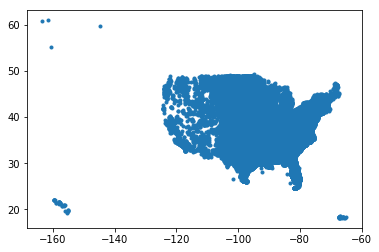

In [7]:
p = plt.scatter(latlong.iloc[:, 1], latlong.iloc[:, 0], marker='.')

plt.show()

Just as we suspected, that's pretty dense data.  We definately need to do some clustering before we 
overlay this on our map.


In [8]:
k_means = KMeans(init = "k-means++", n_clusters = 500, n_init = 12)

So in that line we set our number of clusters to 100 and n_init to 12.  n_init tells the 
model how many times it needs to iterate the calculations for each cluster, moving the 
center on each iteration in order to find the minimum average deviation of each tornado
from the cluster center.  In other words 12 iterations should be enough to find the 
optimum center of each of our 100 clusters.

Now it's time to fit our data to the k-means model.  With 60 thousand tornados, 100 
clusters and 12 iterations per cluster this may take a while.  It takes about 30 minutes
on my Windows 10 PC.  It would be faster on my Ubuntu box but I have that one torn apart.

In [9]:
k_means.fit(latlong)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=500, n_init=12, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

# It worked!  Let's see where it put the cluster centers.

Let's grab the labels for each point in the model using KMeans' .labels_ attribute and 
save it as k_means_labels

In [10]:
k_means_labels = k_means.labels_
k_means_labels

array([360, 115, 315, ..., 455, 384,  59])

We will also get the coordinates of the cluster centers using KMeans' .cluster_centers_ and 
save it as k_means_cluster_centers

In [11]:
k_means_cluster_centers = k_means.cluster_centers_
k_means_cluster_centers

array([[  37.01128655,  -89.64356725],
       [  41.48398058, -105.05359223],
       [  35.38218462,  -97.60947692],
       [  40.80769231,  -80.42316239],
       [  32.45341085,  -83.22139535],
       [  43.39348684,  -96.60236842],
       [  29.83481481,  -95.63888889],
       [  43.81509091, -112.23472727],
       [  42.88787234,  -89.31014184],
       [  38.37673077, -122.01769231],
       [  39.42618182,  -75.57290909],
       [  32.79198758, -103.02447205],
       [  27.95283388,  -82.59993485],
       [  33.67604348,  -86.85813043],
       [  20.23571429, -155.95928571],
       [  39.10853801,  -99.71561404],
       [  48.49192771,  -98.13457831],
       [  30.89426396,  -90.32461929],
       [  38.75992188,  -84.708125  ],
       [  39.90483516,  -93.39362637],
       [  33.92774194,  -78.93827957],
       [  34.87184211, -112.34236842],
       [  33.71453125,  -91.71070312],
       [  44.74364865,  -93.36101351],
       [  32.61138158,  -97.15069079],
       [  48.30241667, -1

Let's convert that numpy array into a pandas dataframe for plotting.

In [12]:
#Creating pandas dataframe from numpy array

locdata = pd.DataFrame({'Latitude':k_means_cluster_centers[:,0],'Longitude':k_means_cluster_centers[:,1]})

locdata.head()


,Latitude,Longitude
0,37.011287,-89.643567
1,41.483981,-105.053592
2,35.382185,-97.609477
3,40.807692,-80.423162
4,32.453411,-83.221395


# Cool, let's plot the centers of those clusters

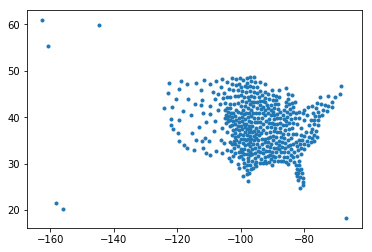

In [13]:
p = plt.scatter(locdata.iloc[:, 1], locdata.iloc[:, 0], marker='.')

plt.show()

So those are the centers of our 500 clusters.  With 60,000 total tornados, each
cluster represents about 120 tornados.  If we went with 1,000 clusters there 
would be about 60 tornados in each cluster.  At 60,000 data points the data is too 
dense to see anything.  But at 500 it looks better.  We'll fiddle around later to 
get a number of clusters that makes sense.


# Let's set up our folium map and Foursquare credentials

In [14]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


In [16]:
address = 'United States'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of the United States are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of the United States are 39.7837304, -100.4458825.


In [19]:
locdata.dtypes

Latitude     float64
Longitude    float64
dtype: object

In [28]:
# create map of the US using latitude and longitude values
map_usa = folium.Map(location=[latitude, longitude], zoom_start=4)

# add markers to map
map = folium.Map(location=[latitude, longitude], zoom_start=4)

# I can add marker one by one on the map
for i in range(0,len(locdata)):
    folium.CircleMarker([locdata.iloc[i]['Latitude'], locdata.iloc[i]['Longitude']],
    radius=2,
    weight=1).add_to(map)

map


Now that's an interesting map.  Each dot represents a cluster of 120 tornados. You can clearly
see "Tornado Alley" (i.e. Texas, Oklahoma, Kansas and Nebraska), the areas of highest density as
far as tornados are concerned.

We could fiddle around with that 120 cluster size number but I think this size of cluster tells 
us what we want to know.  In the areas of greatest tornadic activitiy the dots look suspiciously 
evenly spaced but that is a feature of k-means clustering.  Each dot representing a cluster 
center grabs the 120 tornados nearest it which is what produces that sort of evenly allocated 
whitespace between the dots.

But those aren't the areas we are looking for anyway.  We are looking for the areas of lowest 
density - the least tornadic activity.  Maine doesn't look too bad - only 3 clusters up there.
But it looks like the best areas are going to be western New Mexico, central Nevada or western 
Washington.  All three of those have pretty low activity.

Bearing that in mind, perhaps we should look at some other features of the original dataset 
besides just the density of the data.  Perhaps we should look at the strength of the storms and
the number of fatalities and plot those as well.

There is something to bear in mind, however, about the strength of the storms.  The highest 
rating on the Fujita scale is EF5 which corresponds to wind speeds of over 300 mph.  That's the
fastest wind on the planet - faster than the jetstream, faster than the fastest hurricane.  But
it is very difficult to measure wind speed in a tornado from a distance.  So the Fujita scale 
rates the windspeed by looking at the damage the tornado leaves in it's wake.  The problem with
that is that if a tornado has 300+ mph winds but happens out in the middle of farm land it 
leaves no damage in it's wake and will therefore be rated as an EF0 instead of an EF5.  With 
that caveat in mind, let's revisit our map but add information on EF5 tornados in a different 
color and information on fatalities.

# Add EF5 tornados and fatalities to map

# EF5's are in red, fatalaties in black but scaled by number

In [84]:
# create map of the US using latitude and longitude values
map_usa = folium.Map(location=[latitude, longitude], zoom_start=4)

# I can add marker one by one on the map
for i in range(0,len(locdata)):
    folium.CircleMarker([locdata.iloc[i]['Latitude'], locdata.iloc[i]['Longitude']],
    radius=2,
    weight=1,
    color='blue',
    fill=True,
    fill_color='blue'
    ).add_to(map)

for i in range(0,len(df)):
    if (df.iloc[i]['mag'] == 5):
        folium.CircleMarker([df.iloc[i]['slat'], df.iloc[i]['slon']],
        radius=2,
        weight=1,
        color='crimson',
        fill=True,
        fill_color='crimson'
        ).add_to(map)

for i in range(0,len(df)):
    if (df.iloc[i]['fat'] != 0):
        folium.CircleMarker([df.iloc[i]['slat'], df.iloc[i]['slon']],
        radius=int(df.iloc[i]['fat']/5),
        weight=1,
        color='black',
        fill=False,
        fill_color='black'
        ).add_to(map)

map

Well, there's a representation of all the tornados in the United States from 1950 to 2015.  The blue dots represent the centers of clusters of 120 tornados since if we plotted every single one the whole map would basically be blue.  The red dots are the EF5 tornados - at least the ones that did enough damage to get a rating.  The black circles represent fatalities divided by 5.  Otherwise the black circles would be too big.  But you can clearly see Joplin, Missouri.  The Waco, Texas tornado of 1953 killed 114 people so that shows up pretty well.  The 1953 Flint–Beecher tornado in Flint, Michigan claimed 116 lives.  The map is zoomable so you can zoom in and pan around to explore the data.

The question we set out to answer is where is the safest place to build a trailer park.  Or if you already own a moble home where is the safest place to park it.  Judging from the data I would have to say the answer is somewhere in south central Nevada.


# Let's zoom into south central Nevada

In [100]:
nevLatitude=38.203181 
nevLongitude=-116.572846
map = folium.Map(location=[nevLatitude, nevLongitude], zoom_start=6)

# I can add marker one by one on the map
for i in range(0,len(locdata)):
    folium.CircleMarker([locdata.iloc[i]['Latitude'], locdata.iloc[i]['Longitude']],
    radius=2,
    weight=1,
    color='blue',
    fill=True,
    fill_color='blue'
    ).add_to(map)

for i in range(0,len(df)):
    if (df.iloc[i]['mag'] == 5):
        folium.CircleMarker([df.iloc[i]['slat'], df.iloc[i]['slon']],
        radius=2,
        weight=1,
        color='crimson',
        fill=True,
        fill_color='crimson'
        ).add_to(map)

for i in range(0,len(df)):
    if (df.iloc[i]['fat'] != 0):
        folium.CircleMarker([df.iloc[i]['slat'], df.iloc[i]['slon']],
        radius=int(df.iloc[i]['fat']/5),
        weight=1,
        color='black',
        fill=False,
        fill_color='black'
        ).add_to(map)

map


The dots for the tornado clusters look smaller on this scale but you can see one NW of Las Vegas, one 
East of Carson City and one in the NE of the State which falls south of Elko, Nevada.  So the center 
of the map is pretty equidistant between those points.  If you zoom the map in you will find the answer.

It's Tonopah, Nevada - the safest place in America to build a trailer park!  At least from the 
viewpoint of tornados.  Now rattlesnakes...  That might be a whole other story.

But that's only half of our question.

The other half is which trailer park in the US is the safest from the tornado perspective?  That would 
be a job for Foursquare to figure out...


# Construct the Foursquare search URL for Tonopah, Nevada.

In [121]:
CLIENT_ID = 'your Foursquare ID' # your Foursquare ID
CLIENT_SECRET = 'your Foursquare Secret' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: your Foursquare ID
CLIENT_SECRET:your Foursquare Secret


In [112]:
neighborhood_latitude = nevLatitude # neighborhood latitude value
neighborhood_longitude = nevLongitude # neighborhood longitude value

neighborhood_name = "Tonopah, NV" # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Tonopah, NV are 38.203181, -116.572846.


In [119]:
radius = 120000
LIMIT = 100

url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, neighborhood_latitude, neighborhood_longitude, VERSION, radius, LIMIT)

results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5ce80399351e3d12842d1414'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Current map view',
  'headerFullLocation': 'Current map view',
  'headerLocationGranularity': 'unknown',
  'totalResults': 20,
  'suggestedBounds': {'ne': {'lat': 39.28318208000108,
    'lng': -115.20105464250776},
   'sw': {'lat': 37.12317991999892, 'lng': -117.94463735749224}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4ea30a846c25b62f3da61edb',
       'name': 'Mizpah Hotel',
       'location': {'lat': 38.06828440568951,
        'lng': -117.23075238231367,
        'labeledLatLngs': [{'label': 'display',
          'lat': 38.06828440568951,
          'lng': -117.23

In [120]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [118]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues

,name,categories,lat,lng
0,Mizpah Hotel,Hotel,38.068284,-117.230752
1,Tonopah Brewing Co.,Brewery,38.066119,-117.228793
2,El Marques Mexican Restaurant,Mexican Restaurant,38.071058,-117.232827
3,Little A'Le'Inn,Diner,37.646761,-115.745851
4,Redbox,Video Store,38.367900,-116.514500
5,Stage Stop Cafe,Diner,38.058904,-117.218606
6,Subway,Sandwich Place,38.077614,-117.247212
7,Shell,Gas Station,38.065199,-117.227485
8,Tonopah Station,Hotel,38.058471,-117.218651
9,Best Western Hi-Desert Inn,Hotel,38.066361,-117.228282


Perhaps we shouldn't be too surprised.  The largest geographic area we can search with 
Foursquare is a 75 mile radius.  Tonopah is a small town out in the middle of a big 
desert.  There are only 18 venues within a 75 mile radius and none of them are trailer
parks.  Let's do a Google search and see what it turns up.

Sure enough.  There is one mobile home park in Tonopah and they don't have a website.
The next nearest one is in North Las Vegas which is near the center of one of our 
tornado clusters.  So it would appear that the winner of our effort to find the 
safest trailer park in America is:

Jensen's Trailer Park
789 Central St
Tonopah, NV 89049

Phone: (775) 482-3737

So there you have it campers!  Enjoy a carefree tomorrow in beautiful Tonapah.  Just 
watch for the rattle snakes...
